In [1]:
import os
import sys
import importlib
import pickle
import emcee
import corner
AbsPath = str(os.path.abspath(""))+"/../.."
sys.path.append(AbsPath)
from itertools import cycle
import scipy.stats
import matplotlib.pyplot as plt
from Functions import Functions as F
HMF_fun = F.Make_HMF_Interp()
from Functions.Functions import Make_HMF_Interp
import numpy as np
import matplotlib.pyplot as plt
import colossus.halo.mass_adv as massdefs
from colossus.cosmology import cosmology
from scipy.interpolate import interp1d
cosmology.setCosmology("planck15")
Cosmo =cosmology.getCurrent()

h = Cosmo.h


In [2]:
#Abundance Matching Parameters
Override =\
{\
'M10':12.0,\
'SHMnorm10':0.032,\
'beta10':1.5,\
'gamma10':0.56,\
'M11':0.6,\
'SHMnorm11':-0.014,\
'beta11':-2,\
'gamma11':0.08\
}


AbnMtch =\
{\
'Behroozi13': False,\
'Behroozi18': False,\
'B18c':False,\
'B18t':False,\
'G18':False,\
'G18_notSE':False,\
'G19_SE':False,\
'G19_cMod':False,\
'Lorenzo18':False,\
'Moster': False,\
'Moster10': False,\
'Illustris': False,\
'z_Evo':True,\
'Scatter': 0.15,\
'Override_0': False,\
'Override_z': False,\
'Override': Override,\
'PFT': False,\
'M_PFT1': False,\
'M_PFT2': False,\
'M_PFT3': False,\
'N_PFT1': False,\
'N_PFT2': False,\
'N_PFT3': False,\
'b_PFT1': False,\
'b_PFT2': False,\
'b_PFT3': False,\
'g_PFT1': False,\
'g_PFT2': False,\
'g_PFT3': False,\
'g_PFT4': False,\
'HMevo': False,\
'HMevo_param': None\
}

Paramaters = \
{\
'AbnMtch' : AbnMtch,\
'AltDynamicalTime': 1,\
'NormRnd': 0.5,\
'SFR_Model': 'CE',\
'PreProcessing': False,\
'AltDynamicalTimeB': False\
}



#Subhalomass function parameters macc/M0
Unevolved = {\
'gamma' : 0.22,\
'alpha' : -0.91,\
'beta' : 6,\
'omega' : 3,\
'a' : 1,\
}

11.45 0.4968


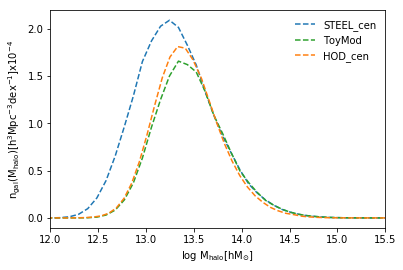

In [3]:
#Load Tinker_HOD
Tkr_hod = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_hod.dat", skiprows=2).T
Tkr_RX2 = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_RX2.dat", skiprows=2).T
#Load STEEL
Fit = ('1.0', True, True, True, 'G19_DPL', 'G19_SE')#('1.0', False, False, True, 'G19_DPL', 'G19_SE')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)



#Plot Full STEEL
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

AbnMtch[Fit[5]] = True
Central_Wt = HMF_fun(AvaHaloMass[Data_z_ix], 0.5)
SM = F.DarkMatterToStellarMass(AvaHaloMass[Data_z_ix]-np.log10(h), 0.5, Paramaters, ScatterOn=False)
Norm = scipy.stats.norm(SM, 0.15)
Prob = 1-Norm.cdf(11.45)
Central_Wt = Central_Wt*Prob
X_cen, Y_cen = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Central_Wt, Scatt = 0.1)
Y_cen = Y_cen*(10**4)
AbnMtch[Fit[5]] = False

#X_sat==X_cen
#plt.plot(X_sat, Y_cen+Y_sat, "-",label ="STEEL", color = "C0")
plt.plot(X_cen, Y_cen, "--",label ="STEEL_cen", color = "C0")
#plt.plot(X_sat, Y_sat, ":",label = "STEEL_sat", color = "C0")



#Central only toy model
Override['M10'] = 12.0
Override['SHMnorm10'] = 0.032
Override['beta10'] = 1.5
Override['gamma10'] = 0.58
Override['M11'] = 0.6
Override['SHMnorm11'] = -0.014
Override['beta11'] = -0.7
Override['gamma11'] = 0.08

AbnMtch['Override_z'] = True
Central_Wt = HMF_fun(AvaHaloMass[Data_z_ix], 0.5)
SM = F.DarkMatterToStellarMass(AvaHaloMass[Data_z_ix]-np.log10(h), 0.5, Paramaters, ScatterOn = False)
Norm = scipy.stats.norm(SM, 0.1)
Prob = 1-Norm.cdf(11.45)
Central_Wt = Central_Wt*Prob
X_cen, Y_cen = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Central_Wt, Scatt = 0.1)
Y_cen = Y_cen*(10**4)
AbnMtch['Override_z'] = False






plt.plot(X_cen, Y_cen, "--",label ="ToyMod", color = "C2")


#"""
#plt.plot(Tkr_hod[0], Tkr_hod[1]+(Tkr_hod[2]/10), "-",label = "HOD", color = "C1")
plt.plot(Tkr_hod[0], Tkr_hod[1], "--",label = "HOD_cen", color = "C1")
#plt.plot(Tkr_hod[0], Tkr_hod[2]/10, ":",label = "HOD_sat", color = "C1")
#"""
"""
plt.plot(Tkr_RX2[0], Tkr_RX2[1]+(Tkr_RX2[2]/10), "-",label = "HOD", color = "C2")
plt.plot(Tkr_RX2[0], Tkr_RX2[1], "--",label = "HOD_cen", color = "C2")
plt.plot(Tkr_RX2[0], (Tkr_RX2[2]/10), ":",label = "HOD_sat", color = "C2")
"""

plt.xlim(12, 15.5)
plt.xlabel("log $\mathrm{M_{halo} [hM_{\odot}]}$")
plt.ylabel("$\mathrm{n_{gal}(M_{halo}) [h^3Mpc^{-3}dex^{-1}]x10^{-4}}$")
plt.legend(frameon = False)
plt.show()


In [37]:
#Load Tinker_HOD
Tkr_hod = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_hod.dat", skiprows=2).T
Tkr_RX2 = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_RX2.dat", skiprows=2).T

#Load STEEL style haloes
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
Fit = ('1.0', False, False, True, 'G19_DPL', 'G19_SE')#('1.0', False, False, True, 'G19_DPL', 'G19_SE')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)
z_arr, halo_masses_sat, number_densitys_sat = F.LoadData_MultiEpoch_SubHalos(Fit)
halo_masses_cen = AvaHaloMass[Data_z_ix]
number_densitys_cen = HMF_fun(halo_masses_cen, 0.5)
#Brute force the gamma sigma space returning a weighting describing the 'goodness of fit' between HOD and the toy model

#Central only toy model
Override['M10'] = 12.0
Override['SHMnorm10'] = 0.032
Override['beta10'] = 1.5
Override['gamma10'] = 0.58
Override['M11'] = 0
Override['SHMnorm11'] = 0
Override['beta11'] = 0
Override['gamma11'] = 0.0

def make_dist(gamma_in, sigma_in, cen_sat = 'cen'):
    """
    #Function to compute the distribution for a given gamma sigma pair
    #Inputs:
    #    gamma_in: high mass slope of the SMHM relation
    #    sigma_in: scatter of the SMHM relation
    #Returns:
    #    [X_cen, Y_cen]: the X and Y values for the distribution
    """
    Override['gamma10'] = gamma_in
    if cen_sat == 'cen':
        halo_masses, number_densitys = halo_masses_cen, number_densitys_cen
    elif cen_sat == 'sat':
        halo_masses, number_densitys_z = halo_masses_sat, number_densitys_sat
        z_bin = np.digitize(0.5, bins = z_arr)
        number_densitys = np.sum(number_densitys_z[z_bin], axis = 0)
    AbnMtch['Override_z'] = True    
    stellar_mass = F.DarkMatterToStellarMass(halo_masses-np.log10(h), 0.5, Paramaters, ScatterOn = False)
    AbnMtch['Override_z'] = False
    norm = scipy.stats.norm(stellar_mass, sigma_in)
    prob = 1-norm.cdf(11.45)
    weights = number_densitys*prob
    X, Y = F.Gauss_Scatt(halo_masses, weights, Scatt = 0.1)
    if cen_sat == 'cen':
        Y = Y*(10**4)
    elif cen_sat == 'sat':
        Y = Y*(10**4)
    return [X, Y]

def compare_dist(hod, toy, cen_sat = 'cen'):
    """
    #Function to compare two distributions and return a least suares value
    #Inputs:
    #    hod: the HOD model distribution 2d distribution [2,N]
    #    toy: the toy model distribution 2d distribution [2,N]
    #Outputs:
    #    least_sq: the least squares value when comparing the two data
    """
    
    #first interpolate over both data sets
    if cen_sat == 'cen':
        hod_interp = interp1d(hod[0], hod[1])
    elif cen_sat == 'sat':
        hod_interp = interp1d(hod[0], hod[2]/10)
    toy_interp = interp1d(toy[0], toy[1])
    
    #choose x values to sample, 100 values over tthe range 12.5 to 15
    x_sample = np.linspace(12.5, 15, num = 100)
    
    #calculate the average square of the distance between the two curves
    least_sq = np.sum(np.power(hod_interp(x_sample) - toy_interp(x_sample),2))/100
    
    return least_sq

In [ ]:
gamma_min = 0.4
gamma_max = 0.7
sigma_min = 0.00
sigma_max = 0.25
gamma_samples = 50
sigma_samples = 50

least_sq=[]
values=[]
for i, gamma_ix in enumerate(np.linspace(gamma_min, gamma_max, num = gamma_samples)):
    least_sq.append([])
    values.append([])
    for sigma_ix in np.linspace(sigma_min, sigma_max, num = sigma_samples):
        toy_dist = make_dist(gamma_ix, sigma_ix)
        least_sq[i].append(compare_dist(Tkr_hod, toy_dist))
        values[i].append([gamma_ix,sigma_ix])

#normalise to make a heatmap
least_sq_norm_cen = np.array(least_sq)/np.sum(least_sq)


#plot heatmap of the fit, np.power here is used to excentuate the maximum set to 1 for true normilisation
fig = plt.imshow(np.power(least_sq_norm_cen.T, 0.7), cmap=plt.cm.viridis, origin =  'lower', extent=[gamma_min, gamma_max,sigma_min, sigma_max], aspect = ((gamma_min-gamma_max)/(sigma_min-sigma_max)))
fig.fig_size = (5, 5)
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\sigma$")
plt.colorbar()
plt.show()

#lambda function to flatten the 2d lists
flatten = lambda l: [item for sublist in l for item in sublist]
#flattending the lists
flat_sq = flatten(least_sq); flat_value = flatten(values)
#extract best fit pair
min_value = min(flat_sq)
best_fit = flat_value[flat_sq.index(min_value)]
print("Least Squares = ", min_value, "at gamma, sigma = ", best_fit)

#get and plot best fit
x, y = make_dist(best_fit[0], best_fit[1])
plt.plot(x, y, "--",label ="ToyMod")
plt.plot(Tkr_hod[0], Tkr_hod[1], "--",label = "HOD_cen", color = "k")
plt.xlim(12, 15.5)
plt.xlabel("log $\mathrm{M_{halo} [hM_{\odot}]}$")
plt.ylabel("$\mathrm{n_{gal}(M_{halo}) [h^3Mpc^{-3}dex^{-1}]x10^{-4}}$")
plt.legend(frameon = False)
plt.show()



In [ ]:
gamma_min = 0.4
gamma_max = 0.7
sigma_min = 0.00
sigma_max = 0.25
gamma_samples = 50
sigma_samples = 50

least_sq=[]
values=[]
for i, gamma_ix in enumerate(np.linspace(gamma_min, gamma_max, num = gamma_samples)):
    least_sq.append([])
    values.append([])
    for sigma_ix in np.linspace(sigma_min, sigma_max, num = sigma_samples):
        toy_dist = make_dist(gamma_ix, sigma_ix, cen_sat = 'sat')
        least_sq[i].append(compare_dist(Tkr_hod, toy_dist, cen_sat = 'sat'))
        values[i].append([gamma_ix,sigma_ix])

#normalise to make a heatmap
least_sq_norm_sat = np.array(least_sq)/np.sum(least_sq)

#plot heatmap of the fit, np.power here is used to excentuate the maximum set to 1 for true normilisation
fig = plt.imshow(np.power(least_sq_norm_sat.T, 0.7), cmap=plt.cm.viridis, origin =  'lower', extent=[gamma_min, gamma_max,sigma_min, sigma_max], aspect = ((gamma_min-gamma_max)/(sigma_min-sigma_max)))
fig.fig_size = (5, 5)
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\sigma$")
plt.colorbar()
plt.show()

#lambda function to flatten the 2d lists
flatten = lambda l: [item for sublist in l for item in sublist]
#flattending the lists
flat_sq = flatten(least_sq); flat_value = flatten(values)
#extract best fit pair
min_value = min(flat_sq)
best_fit = flat_value[flat_sq.index(min_value)]
print("Least Squares = ", min_value, "at gamma, sigma = ", best_fit)

#get and plot best fit
x, y = make_dist(best_fit[0], best_fit[1], cen_sat = "sat")
plt.plot(x, y, "--",label ="ToyMod")

#HOD
plt.plot(Tkr_hod[0], Tkr_hod[2]/10, "-",label = "HOD_sat", color = "C0")
plt.plot(Tkr_RX2[0], (Tkr_RX2[2]/10), "-",label = "HOD_sat_RX2", color = "C7")

plt.xlim(12, 15.5)
plt.xlabel("log $\mathrm{M_{halo} [hM_{\odot}]}$")
plt.ylabel("$\mathrm{n_{gal}(M_{halo}) [h^3Mpc^{-3}dex^{-1}]x10^{-4}}$")
plt.legend(frameon = False)
plt.show()

11.45 0.4968
11.45 0.4968
11.45 0.4968
11.45 0.4968
11.45 0.4968


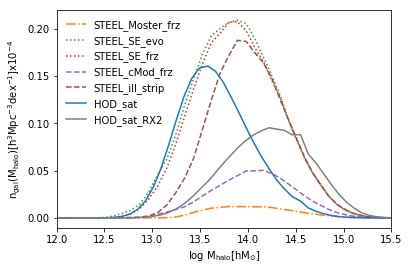

In [11]:
#Load Tinker_HOD
Tkr_hod = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_hod.dat", skiprows=2).T
Tkr_RX2 = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_RX2.dat", skiprows=2).T


#Load STEEL
Fit = ('1.0', False, False, True, 'G19_DPL', 'Moster')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

#Plot STEEL sat
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

plt.plot(X_sat, Y_sat, "-.",label = "STEEL_Moster_frz", color = "C1")

Output = np.vstack((X_sat, Y_sat))


#Load STEEL
Fit = ('1.0', True, True, True, 'G19_DPL', 'G19_SE')#('1.0', False, False, True, 'G19_DPL', 'G19_SE')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

#Plot STEEL sat
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

plt.plot(X_sat, Y_sat, ":",label = "STEEL_SE_evo", color = "C2")

Output = np.vstack((Output, Y_sat))

#Load STEEL
Fit = ('1.0', False, False, True, 'G19_DPL', 'G19_SE')#('1.0', False, False, True, 'G19_DPL', 'G19_SE')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

#Plot STEEL sat
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

plt.plot(X_sat, Y_sat, ":",label = "STEEL_SE_frz", color = "C3")

Output = np.vstack((Output, Y_sat))

#Load STEEL
Fit = ('1.0', False, False, True, 'G19_DPL', 'G19_cMod')#('1.0', False, False, True, 'G19_DPL', 'G19_SE')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

#Plot STEEL sat
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

plt.plot(X_sat, Y_sat, "--",label = "STEEL_cMod_frz", color = "C4")

Output = np.vstack((Output, Y_sat))

#Load STEEL
Fit = ('1.0', True, False, True, 'Illustris', 'Illustris')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

#Plot STEEL sat
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

plt.plot(X_sat, Y_sat, "--",label = "STEEL_ill_strip", color = "C5")

Output = np.vstack((Output, Y_sat))

#HOD
plt.plot(Tkr_hod[0], Tkr_hod[2]/10, "-",label = "HOD_sat", color = "C0")
plt.plot(Tkr_RX2[0], (Tkr_RX2[2]/10), "-",label = "HOD_sat_RX2", color = "C7")

plt.xlim(12, 15.5)
plt.xlabel("log $\mathrm{M_{halo} [hM_{\odot}]}$")
plt.ylabel("$\mathrm{n_{gal}(M_{halo}) [h^3Mpc^{-3}dex^{-1}]x10^{-4}}$")
plt.legend(frameon = False)
plt.show()

np.savetxt("StewPaper.txt", Output)